# Data Science Interview Project (Tanmay Sharma, 2023-10-03)

## The Setup

Your CFO appears at your workspace, visibly frustrated and worried. The manual process of reporting spending for various GCP vendors like NetApp, Inc. is not just slow, but also error-prone. The finance team is bogged down with laborious data manipulation to aggregate spending across different vendors, and errors often slip through. For example, they often have to sift through extensive line-by-line expenditures to group all spending from GCP NetApp products, Inc. services under a single "GCP NetApp" category.

The CFO is not happy with the inefficiency, errors, and delays this causes in financial reporting. He is keen on leveraging technology to solve this issue and looks to you for a solution.

---

## The Request

The CFO has two main objectives:

1. Eliminate the manual work and errors associated with the current process.
2. Use the aggregated data to accurately allocate spending among vendors and, hopefully, derive additional financial insights.

### Generalize the methodology for similar projects

To achieve these goals, the CFO wants you to develop an automated reporting tool with the following features:

- **Run Automatically**: The tool should run automatically at the end of each week.
- **Data Collection**: Pull in raw spending data for different GCP vendors. The data for this project was pre-aggregated from parquet files stored in a datalake.
- **Data Aggregation**: Aggregate the spending for each Seller (e.g., group all GCP NetApp, Inc. spending under "GCP NetApp"). Group all related Seller names and normalize to a canonical name (either defined by you or publicly known). For example, there are multiple spellings of ‘Center for Internet Security’ in the data. The final spend should be aggregated by those canonical Seller names. Feel free to utilize Product column as well to guide you. 
- **Report Generation**: Generate a summarized report that breaks down the spending by vendor. You can include a section for additional insights.

---

## Additional Guidelines

- **Libraries**: Use any libraries that strike your fancy.
- **Time Limit**: Please limit the time you spend on the test to under 4 hours. If you spend more time than that, please let us know.
- **Simplifying Assumptions**: Feel free to make any simplifying assumptions to help you get to an MVP in under 4 hours.

---

## What We Want to See

- How you approach the problem is more important than the final product given the 4-hour time constraint.
- We expect to see python code and data outputs.
- Feel free to call out additional steps you would want to explore/take if you had more time.

---

### Table of Contents
- [Objective](#objective)
- [Assumptions](#assumptions)
- [Exploratory Data Analysis (EDA) Summary](#eda)
- [Modeling](#modeling)
- [Results](#results)
- [Future Work](#future-work)
- [EDA Detailed](#eda-code)

---

## Objective <a name="objective"></a>
Brief description about the main goal of the project. What problem am I trying to solve, and what are the objectives of the analysis?.

`Performing an EDA on data.csv.`

1. Understand feature space.
2. Explore algorithms for aggregation.

## Assumptions <a name="assumptions"></a>
Listing down any assumptions I've made during the course of the analysis. Assumptions might include data quality, feature relevance, or any other important considerations.
1. **Data Integrity**: The assumption that the data in the CSV file is accurate and complete. Any erroneous data is not explicitly addressed in the analysis.
2. **Canonical Seller Mapping**: The mapping of Seller names to canonical names assumes that similar-sounding or spelling variations correspond to the same vendor.
3. **Fuzzy Matching Threshold**: A predefined threshold (fuzzy matching score) is used to determine whether two Seller names are considered similar or not. The choice of this threshold was based on trial and error and may need tuning based on the specific dataset.
4. **Visualization Choices**: The choice of visualization techniques assumes that they effectively represent and communicate the data patterns. Other visualization methods could reveal different insights.
5. **Categorical Analysis**: The analysis treats the 'UsageType' and 'Region' columns as categorical variables. Different encoding or feature engineering approaches may be needed for more sophisticated analysis.
6. **Data Preprocessing**: The code assumes that the data does not require extensive preprocessing, such as handling missing values, outliers, or data transformations. Depending on the dataset, additional data cleaning steps may be needed.
7. **Analytical Heuristics**: I've employed analytical heuristics and understand that some of the assumptions can be updated with more business/domain knowledge.
8. **Workflow**: I've focused more on the workflow and problem solving approach. 
9. **Programming Practices**: I've tried to employ best programming practices such as using functions and modularity wherever possible, though I think that the code can be further optimized for efficiency.
10. **System Design**: The system design that follows from this EDA was done with a general outline without any specific emphasis to try and optimize for factors such as latency, accuracy, etc.

## Exploratory Data Analysis (EDA) Summary <a name="eda"></a>
An overview of the data exploration process highlighting any interesting insights that I've gained from examining the data. Visualizations, and summary statistics are included in the detailed EDA section.
1. No nulls or missing values are present.
2. Seller with highest aggregated cost is '41748', this could be a data consistency/availability error.


## Results <a name="results"></a>
Results of the analysis, including any key findings, and any actionable insights.
1. After having completed the EDA, I proceeded to build a system level design for an automated tool.
2. Different steps of the EDA, helped in identifying the HLD and functionality of the different system components.

## Future Work <a name="future-work"></a>
Discussing potential future directions for this project.

1. This analysis was carried out keeping in mind the current dataset size, further optimizations can be done for larger datasets with Spark to leverage parallelization/ distributed computing.
2. Try to better understand the feature set to be able to apply any necessary imputations, transformations, feature engineering, or other preprocessing techniques.
3. Given more time and auxiliary, more features can be built into the dataset and then feature selection done using techniques such as RFECV, forward selection or L1 regularization in case we need to perform downstream modeling.
4. With the presence of more features, predictive modeling can be performed to forecast trends.

* * *

Running the Jupyter Notebook:

- I've used Python for this assessment and imported relevant libraries wherever deemed necessary.
- I've provided a requirements.txt file including all the packages used in the code.
- I've tried to document my thought process as well as add relevant code-comments.
- Please embed the data file under a data folder in order to facilitate running this notebook without needing to change the filepath in the code.

* * *

In [1]:
#Importing Relevant Libraries
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from datetime import datetime, timedelta
import random

In [2]:
import pkg_resources

# List of packages to include in the requirements.txt
packages = [
    'pandas',
    'fuzzywuzzy',
    'matplotlib',
    'seaborn',
]

# Function to get the version of a package
def get_package_version(package):
    try:
        return pkg_resources.get_distribution(package).version
    except pkg_resources.DistributionNotFound:
        return None

# Generating the requirements.txt content
requirements = []
for package in packages:
    version = get_package_version(package)
    if version:
        requirements.append(f"{package}=={version}")

# Write the requirements.txt file
with open('requirements.txt', 'w') as file:
    file.write('\n'.join(requirements))

print("requirements.txt file generated successfully.")

requirements.txt file generated successfully.


## EDA Detailed <a name="eda-code"></a>

In [3]:
#Reading in the csv file into pandas dataframe
df = pd.read_csv('../data_lake_storage/data/data.csv')

In [4]:
#exploring the feature-count and datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductName  711 non-null    object 
 1   Seller       711 non-null    object 
 2   UsageType    711 non-null    object 
 3   Region       711 non-null    object 
 4   CostUSD      711 non-null    float64
dtypes: float64(1), object(4)
memory usage: 27.9+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CostUSD,711.0,1079.661616,9973.995301,-1074.190183,0.0,0.0,4.287907,230604.04


In [6]:
# Looking at the first few entries
df.head()

,ProductName,Seller,UsageType,Region,CostUSD
0,GCP Fastly for GCP Marketplace,fastly-public-46a6,D27A-A4CF-6B01:Fastlypublic46a6,(not set),230604.040000
1,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,64A1-DB8B-7CDA:41748,us-central1,64513.119782
2,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,64A1-DB8B-7CDA:41748,us-west4,62623.550218
3,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,009E-7D88-7AE8:41748,us-east4,53447.398344
4,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,009E-7D88-7AE8:41748,us-west2,50071.497941


In [7]:
#Building a helper function to check further for null-count and unique-values
def null_and_unique_counter(df: pd.DataFrame, columns_list: list) -> pd.DataFrame:
    """
    Function to take in a pandas dataframe and return the null count and #unique values for its features
    
    Parameters
    ----------
    df : pd.DataFrame
        a pandas dataframe
    columns_list : list
        list of all column names of interest in the dataframe

    Returns
    ----------
    feature_counts: pd.DataFrame
        a pandas dataframe showing the null count, null count percentage and #unique values 
        for all features in the columns_list
    
    """
    #dictionary for results of each feature
    feat_dict = {}
    
    for feature in columns_list:
        if feature in feat_dict:
            feat_dict[feature].append(df[feature].isnull().sum())
            feat_dict[feature].append(((df[feature].isnull().sum())/len(df[feature]))*100)
            feat_dict[feature].append(len(df[feature].value_counts()))
        else:
            feat_dict[feature] = [df[feature].isnull().sum()]
            feat_dict[feature].append(((df[feature].isnull().sum())/len(df[feature]))*100)
            feat_dict[feature].append(len(df[feature].value_counts()))
    
    # Storing the details about the features in a dataframe
    feature_counts = pd.DataFrame.from_dict(feat_dict).rename(index = {0:"null_count", 1:"null_count_pct", 2:"num_unique_values"})
    
    #Returning the results ordered by null-count percentage
    return (feature_counts.T).sort_values(by = "null_count_pct", ascending=False)

In [8]:
columns_list = df.columns.to_list()

In [9]:
null_and_unique_counter(df, columns_list)

,null_count,null_count_pct,num_unique_values
ProductName,0.0,0.0,183.0
Seller,0.0,0.0,59.0
UsageType,0.0,0.0,241.0
Region,0.0,0.0,37.0
CostUSD,0.0,0.0,301.0


In [10]:
# function to find the best match for a Seller name
def find_best_match(query, choices):
    # fuzzywuzzy's process method to find the best match
    result = process.extractOne(query, choices)
    
    # Defining a threshold score (adjustable) to consider a match
    threshold = 80
    
    if result and result[1] >= threshold:
        return result[0]
    else:
        return query

In [11]:
# Dictionary to map Seller names to canonical names
canonical_sellers = {}

# Iterating through unique Seller names in the dataset
unique_sellers = df['Seller'].unique()
for seller in unique_sellers:
    # Check if a similar seller name exists in the dictionary
    existing_canonical_seller = find_best_match(seller, canonical_sellers.keys())
    
    # If a similar seller name is found, use the existing canonical name
    if existing_canonical_seller in canonical_sellers:
        canonical_sellers[seller] = canonical_sellers[existing_canonical_seller]
    else:
        canonical_sellers[seller] = seller

In [12]:
# Function to map Seller names to canonical names using the dictionary
def map_to_canonical(seller):
    return canonical_sellers.get(seller, seller)

In [13]:
# Applying the mapping function to the 'Seller' column
df['CanonicalSeller'] = df['Seller'].apply(map_to_canonical)

In [14]:
# Grouping the data by 'CanonicalSeller' and sum the 'CostUSD' for each group
aggregated_data = df.groupby('CanonicalSeller')['CostUSD'].sum().reset_index()

In [15]:
# # Optionally, can include the 'ProductName' column for more detailed grouping
# aggregated_data = df.groupby(['CanonicalSeller', 'Product'])['CostUSD'].sum().reset_index()

In [16]:
# Sorting the aggregated data by 'CanonicalSeller' alphabetically
aggregated_data = aggregated_data.sort_values(by='CanonicalSeller')

In [17]:
# Saving the aggregated data to a new CSV file
aggregated_data.to_csv('aggregated_data.csv', index=False)

In [18]:
# Displaying the aggregated data
aggregated_data

,CanonicalSeller,CostUSD
0,41748,310782.552244
1,Aiven,5091.731000
2,AlmaLinux,0.000000
3,Aviatrix,0.000000
4,Bitnami,0.000000
5,CIS (Center for Internet Security),2796.134046
6,Canonical,12194.014768
7,Check Point Software Technologies,0.000000
8,Cisco Systems,0.000000
9,Citrix,0.000000


### Visualizations and Insights

In [19]:
# Summarized report by Vendor
vendor_report = copy.deepcopy(aggregated_data)
vendor_report.columns = ['Vendor', 'TotalSpending']

In [20]:
# Grouping the data by 'UsageType' and sum the 'CostUSD' for each group
usage_type_report = df.groupby('UsageType')['CostUSD'].sum().reset_index()
usage_type_report = usage_type_report.sort_values(by='CostUSD', ascending=False)

In [21]:
# Grouping the data by 'Region' and sum the 'CostUSD' for each group
region_report = df.groupby('Region')['CostUSD'].sum().reset_index()
region_report = region_report.sort_values(by='CostUSD', ascending=False)

Text(0, 0.5, 'Vendor')

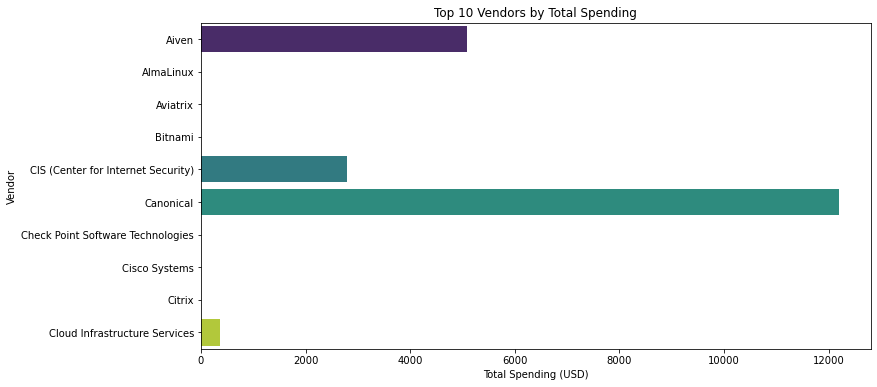

In [22]:
# Plotting the Total Spending by Vendor
plt.figure(figsize=(12, 6))

# Toggle between index 0 and 1 since 0 doesn't seem meaningful
start = 1
sns.barplot(x='TotalSpending', y='Vendor', data=vendor_report.iloc[start:].head(10), palette='viridis')
plt.title('Top 10 Vendors by Total Spending')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Vendor')

Text(0, 0.5, 'Usage Type')

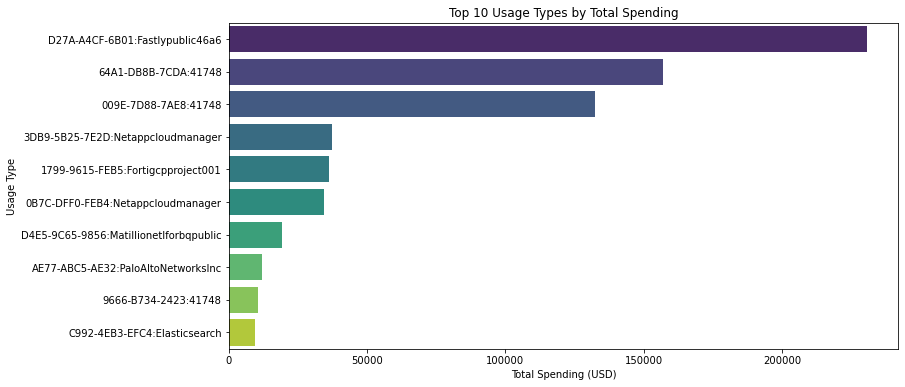

In [23]:
# Plotting the Total Spending by UsageType
plt.figure(figsize=(12, 6))
sns.barplot(x='CostUSD', y='UsageType', data=usage_type_report.head(10), palette='viridis')
plt.title('Top 10 Usage Types by Total Spending')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Usage Type')

Text(0, 0.5, 'Region')

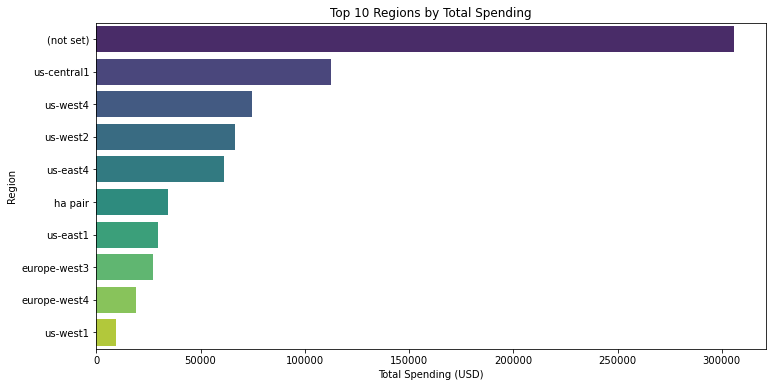

In [24]:
# Plotting the Total Spending by Region
plt.figure(figsize=(12, 6))
sns.barplot(x='CostUSD', y='Region', data=region_report.head(10), palette='viridis')
plt.title('Top 10 Regions by Total Spending')
plt.xlabel('Total Spending (USD)')
plt.ylabel('Region')

In [25]:
# Saving the summarized report to a new CSV file
vendor_report.to_csv('vendor_report.csv', index=False)

In [26]:
# Displaying the summarized report by Vendor
vendor_report.head(10)

,Vendor,TotalSpending
0,41748,310782.552244
1,Aiven,5091.731000
2,AlmaLinux,0.000000
3,Aviatrix,0.000000
4,Bitnami,0.000000
5,CIS (Center for Internet Security),2796.134046
6,Canonical,12194.014768
7,Check Point Software Technologies,0.000000
8,Cisco Systems,0.000000
9,Citrix,0.000000


In [27]:
# Displaying the top Usage Types by Total Spending
print("\nTop 10 Usage Types by Total Spending:")
usage_type_report.head(10)


Top 10 Usage Types by Total Spending:


,UsageType,CostUSD
191,D27A-A4CF-6B01:Fastlypublic46a6,230604.040000
84,64A1-DB8B-7CDA:41748,157038.990137
0,009E-7D88-7AE8:41748,132456.208232
47,3DB9-5B25-7E2D:Netappcloudmanager,37235.462378
18,1799-9615-FEB5:Fortigcpproject001,36404.258821
9,0B7C-DFF0-FEB4:Netappcloudmanager,34583.510829
194,D4E5-9C65-9856:Matillionetlforbqpublic,19117.822320
154,AE77-ABC5-AE32:PaloAltoNetworksInc,12066.202075
134,9666-B734-2423:41748,10571.245502
185,C992-4EB3-EFC4:Elasticsearch,9549.286500


In [28]:
# Displaying the top Regions by Total Spending
print("\nTop 10 Regions by Total Spending:")
region_report.head(10)


Top 10 Regions by Total Spending:


,Region,CostUSD
0,(not set),305897.194167
28,us-central1,112592.504122
36,us-west4,74695.489608
34,us-west2,66558.036432
30,us-east4,61145.178985
21,ha pair,34583.510829
29,us-east1,29422.352564
17,europe-west3,27148.843855
18,europe-west4,18926.545020
33,us-west1,9527.335457


### Exploring more visualizations with assumptions and mock-data

In [29]:
# Mock data with start and end dates for the date range
start_date = datetime(2023, 7, 1)
end_date = datetime(2023, 9, 30)

In [30]:
# Generating random dates within the specified range for each row
date_column = []
for _ in range(len(df)):
    random_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))
    date_column.append(random_date)

In [31]:
# Adding the date column to the DataFrame
df['Date'] = date_column

In [32]:
df.head()

,ProductName,Seller,UsageType,Region,CostUSD,CanonicalSeller,Date
0,GCP Fastly for GCP Marketplace,fastly-public-46a6,D27A-A4CF-6B01:Fastlypublic46a6,(not set),230604.040000,fastly-public-46a6,2023-08-20
1,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,64A1-DB8B-7CDA:41748,us-central1,64513.119782,41748,2023-08-17
2,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,64A1-DB8B-7CDA:41748,us-west4,62623.550218,41748,2023-09-24
3,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,009E-7D88-7AE8:41748,us-east4,53447.398344,41748,2023-08-10
4,"GCP NetApp, Inc. NetApp Cloud Volumes Service",41748,009E-7D88-7AE8:41748,us-west2,50071.497941,41748,2023-07-31


Text(0, 0.5, 'Total Spending (USD)')

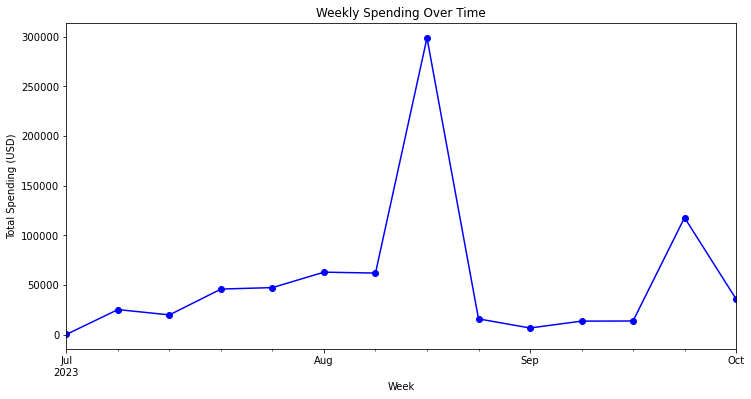

In [33]:
# Creating a time series plot of Weekly Spending
plt.figure(figsize=(12, 6))
df['Date'] = pd.to_datetime(df['Date'])  # Replace 'Date' with your date column name
weekly_spending = df.resample('W', on='Date')['CostUSD'].sum()
weekly_spending.plot(marker='o', linestyle='-', color='b')
plt.title('Weekly Spending Over Time')
plt.xlabel('Week')
plt.ylabel('Total Spending (USD)')